Intro : 
Les libraries permettant de faire l'SNA sont : networkx(python single machine) et graphframes (spark distribué)
Notre Use case va être la detection des communautés du réseau Orange CIV et extraire les noeuds (MSISDN) leaders
Pour connaitre l'importance des noeuds dans le réseau on va utiliser l'algorithme pageRank (https://en.wikipedia.org/wiki/PageRank) qui est disponible sous networkx et graphframes.
Pour la détection des communautés on va utiliser la méthode de Louvain (https://en.wikipedia.org/wiki/Louvain_method)
(https://github.com/taynaud/python-louvain) 

In [2]:
!pip install Faker
!pip install xlrd
!pip install networkx
!pip install scipy

In [2]:
from faker import Faker
fake = Faker()
import random
from random import randrange
import datetime 
from dateutil.relativedelta import *
import networkx as nx
import matplotlib.pyplot as plt
import xlrd

In [3]:
CustomerNumber=100
OperatorNumber = 3
max_call_number = 1

In [4]:
class Operator:
    def __init__(self,name,marketshare):
        self.name = name
        self.marketshare = marketshare
        self.customers = []
        
    def info(self):
        print(self.name)

In [5]:
def CreateOperator(OperatorNumber = OperatorNumber):
    operators = []
    last_marketshare = 0
    
    for i in range(OperatorNumber):
        if i==0:
            ms = random.randint(0,100)
            last_marketshare += ms
            o = Operator(fake.company(),(ms/100))
            operators.append(o)
        elif i==OperatorNumber-1:
            o = Operator(fake.company(),((100-last_marketshare)/100))
            operators.append(o)    
        
        else:
            ms = random.randint(0,(100-last_marketshare))
            o = Operator(fake.company(),(ms/100))
            operators.append(o)
            last_marketshare += ms
    return operators

In [6]:
class Customer:
    def __init__(self,customerid,msisdn):
        self.customerid = customerid
        self.msisdn = msisdn
        self.operator = ""
        self.contacts = []
        self.call_records = []
        
    def info(self):
        print(self.customerid+"\n"+self.msisdn)

In [7]:
def CreatCustomer(CustomerNumber = CustomerNumber):
    if CustomerNumber % 100 != 0:
        print("""Please enter the number of customers in 100 or its multiples....""")
    else:
        customers = []
        for i in range(CustomerNumber):
            while True:
                msisdn = fake.msisdn()
                customerid = fake.isbn10(separator="")
                if int(msisdn[0])!=0 and int(customerid[0])!=0:
                    break
            #print(msisdn,customerid)
            c = Customer(customerid,msisdn)
            customers.append(c)
        return customers

In [8]:
operators = CreateOperator()
created_customers = CreatCustomer()
customers_4_operators = created_customers.copy()
for i in range(len(operators)):
    for j in range(int(operators[i].marketshare*100)):
        c = customers_4_operators.pop()
        c.operator = operators[i]
        operators[i].customers.append(c)

In [9]:
for c in created_customers:
    for i in range(random.randint(0,CustomerNumber)):
        possible_contact = random.choice(created_customers)
        if possible_contact not in c.contacts and possible_contact.msisdn!=c.msisdn:
            c.contacts.append(possible_contact)

In [10]:
class CallRecord():
    def __init__(self,caller,called,timestamp,duration):
        self.CDRNo = "".join(fake.itin().split("-"))
        self.caller = caller
        self.called = called
        self.timestamp = timestamp
        self.duration = duration #Second
        
    def info(self):
        print(self.CDRNo)

In [11]:
def random_date():
    start = datetime.datetime(2020, 9, 20,13,0)
    start += datetime.timedelta(minutes=randrange(1000))
    start += datetime.timedelta(days=randrange(0,30))
    start += relativedelta(months=randrange(2,12))
    return start

In [51]:
"""CDR = []
for c in created_customers:
    for contact in c.contacts:
        for i in range(1,random.randint(1,max_call_number)):
            cdr = CallRecord(caller=c,called=contact,timestamp=random_date().strftime("%d-%m-%y %H:%M"),duration=random.randint(0,120*60))
            c.call_records.append(cdr)
            CDR.append(cdr)
            print(c.msisdn,contact.msisdn,random_date().strftime("%d-%m-%y %H:%M"),random.randint(0,120*60))"""

In [14]:
import pandas as pd
CDR = []
for c in created_customers:
    for contact in c.contacts:
            cdr = CallRecord(caller=c,called=contact,timestamp=random_date().strftime("%d-%m-%y %H:%M"),duration=random.randint(0,120*60))
            c.call_records.append(cdr)
            CDR.append(cdr)
            print(c.msisdn,contact.msisdn,random_date().strftime("%d-%m-%y %H:%M"),random.randint(0,120*60))

4849686902975 7003330266196 05-06-21 18:11 4930
4849686902975 7046835136693 19-09-21 16:59 892
4849686902975 3929947385824 24-01-21 14:43 3116
4849686902975 2238003679663 13-05-21 21:10 2459
4849686902975 1879984510039 21-12-20 19:35 1947
4849686902975 6158508360706 23-08-21 03:30 3194
4849686902975 8029558256772 26-11-20 21:52 2988
4849686902975 2553169233410 24-11-20 03:07 289
4849686902975 8236636627913 05-05-21 18:46 6594
4849686902975 9867089001859 29-12-20 03:24 4084
4849686902975 4134236512196 20-05-21 01:40 5031
4849686902975 1145801792132 12-01-21 21:06 2645
4849686902975 5042698460801 25-08-21 05:08 3898
4849686902975 6400905634996 30-11-20 20:56 955
4849686902975 1038898409205 24-02-21 02:18 764
4849686902975 7448107616613 04-04-21 22:20 5412
4849686902975 4968261635085 12-03-21 03:07 1250
4849686902975 3541957191599 04-06-21 14:27 5015
4849686902975 5287728190775 04-08-21 02:06 1279
4849686902975 5522709573610 04-04-21 19:20 2908
4849686902975 5454576244521 14-08-21 20:30 3

In [15]:
network_dict = {}
for cdr in CDR:
    connection = cdr.caller.msisdn+"->"+cdr.called.msisdn
    
    if connection not in network_dict:
        network_dict[connection]=1
    else:
        network_dict[connection]+=1

len(network_dict)

3438

In [16]:
G_asymmetric = nx.DiGraph()
for c in network_dict:
    G_asymmetric.add_edge(c.split("->")[0],c.split("->")[1])
    
print(nx.info(G_asymmetric))

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 3438
Average in degree:  34.3800
Average out degree:  34.3800


In [17]:
G=nx.DiGraph()
for c in network_dict:
    G.add_edge(c.split("->")[0],c.split("->")[1], weight=network_dict[c])
    
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 3438
Average in degree:  34.3800
Average out degree:  34.3800


(0.0, 1.0, 0.0, 1.0)

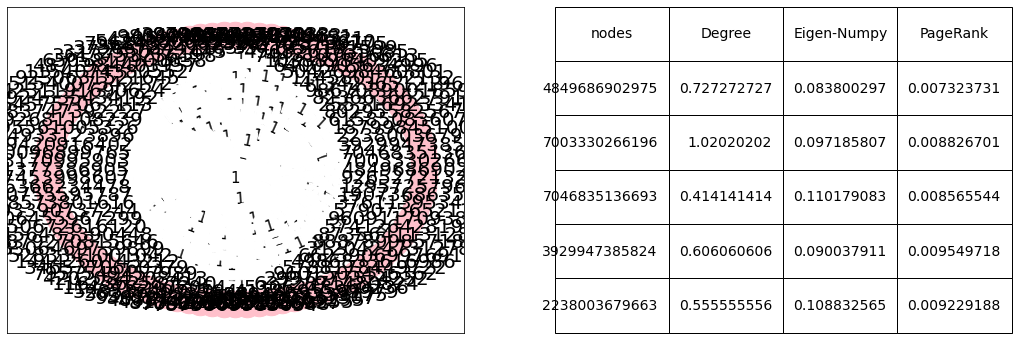

In [18]:
import pandas as pd 
import numpy as np
df = pd.DataFrame()
df['nodes'] = nx.eigenvector_centrality_numpy(G)
df['Degree'] = np.round(list(nx.degree_centrality(G).values()), decimals=9)
df['Eigen-Numpy'] = np.round(list(nx.eigenvector_centrality_numpy(G).values()), decimals=9)
df['PageRank'] = np.round(list(nx.pagerank(G).values()), decimals=9)

fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(121)

edge_labels = [((str(u), str(v)), d['weight']) for (u, v, d) in G.edges(data=True)]
edge_labels = dict(edge_labels)

pos = nx.circular_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='pink', ax=ax1)

# edge weights
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15, ax=ax1)

nx.draw_networkx_edges(G, pos, width=6, alpha=0.5, edge_color='grey', style='dashed', ax=ax1)

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif', ax=ax1)

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1]
df=df.head(5)#####################
ax2.axis('off')
mpl_table = ax2.table(cellText = df.values, rowLabels = None, bbox=bbox, colLabels=df.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

plt.axis('off')

In [34]:
c.msisdn

'6427378840110'

In [26]:
!pip install python-louvain


     |████████████████████████████████| 204 kB 1.8 MB/s eta 0:00:01
  Created wheel for python-louvain: filename=python_louvain-0.15-py3-none-any.whl size=9401 sha256=18aac46f1c5e45dd73b6d72e1a7068f20421e2da2484e7939d287a5a77f7b62b
  Stored in directory: /home/jovyan/.cache/pip/wheels/c8/68/21/d04741956802581119d875a0d9fce6895e8f9ffae71223f3e3
Successfully built python-louvain


In [19]:


import community
G_undirected = G.to_undirected()


partition = community.best_partition(G_undirected,weight='weight')

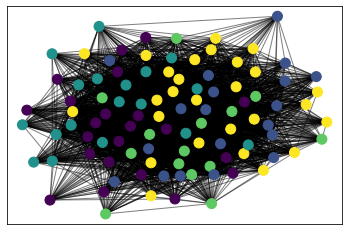

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# visualization
pos = nx.spring_layout(G_undirected)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_undirected, pos, partition.keys(), node_size=100,cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5)
plt.show()

In [21]:
print(partition.values())

dict_values([0, 4, 2, 4, 4, 4, 2, 0, 3, 4, 4, 0, 1, 3, 0, 2, 3, 1, 0, 0, 3, 4, 4, 0, 0, 2, 4, 3, 4, 1, 1, 1, 0, 2, 4, 1, 2, 4, 4, 4, 0, 2, 4, 1, 3, 4, 3, 2, 1, 3, 2, 1, 3, 1, 4, 0, 2, 1, 0, 4, 4, 0, 0, 3, 2, 3, 4, 1, 2, 1, 0, 3, 2, 0, 3, 4, 1, 3, 0, 4, 4, 1, 2, 1, 2, 0, 1, 4, 2, 0, 2, 4, 1, 4, 1, 0, 2, 0, 4, 0])


In [22]:
for node in G_undirected.nodes(): 
    print(node, nx.eigenvector_centrality(G_undirected, max_iter=1000)[node])

4849686902975 0.10430706467139692
7003330266196 0.12948286976707277
7046835136693 0.07702626920087789
3929947385824 0.08892280242770072
2238003679663 0.08596925522369268
1879984510039 0.10173742174261316
6158508360706 0.11120532571139356
8029558256772 0.06997440060907426
2553169233410 0.10645473477603556
8236636627913 0.11862140686731334
9867089001859 0.11466797367166716
4134236512196 0.10818667843401777
1145801792132 0.08689725886370794
5042698460801 0.08533297887036594
6400905634996 0.12922661006589067
1038898409205 0.101085326031092
7448107616613 0.08084931842348553
4968261635085 0.08362128544789828
3541957191599 0.09932089448235186
5287728190775 0.09133117566828015
5522709573610 0.1048782933643705
5454576244521 0.1273111765378631
9071354098691 0.07360226386676116
4346313194983 0.07983355915239572
7998271397013 0.11890367110836537
9696374212333 0.08984104293452566
3943845597910 0.08982558425305144
4842397440574 0.06016691013288167
9806096539941 0.10612819458873653
4305270994922 0.11

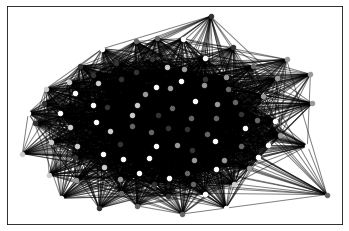

In [23]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G_undirected)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G_undirected, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G_undirected,pos, alpha=0.5)
plt.show()

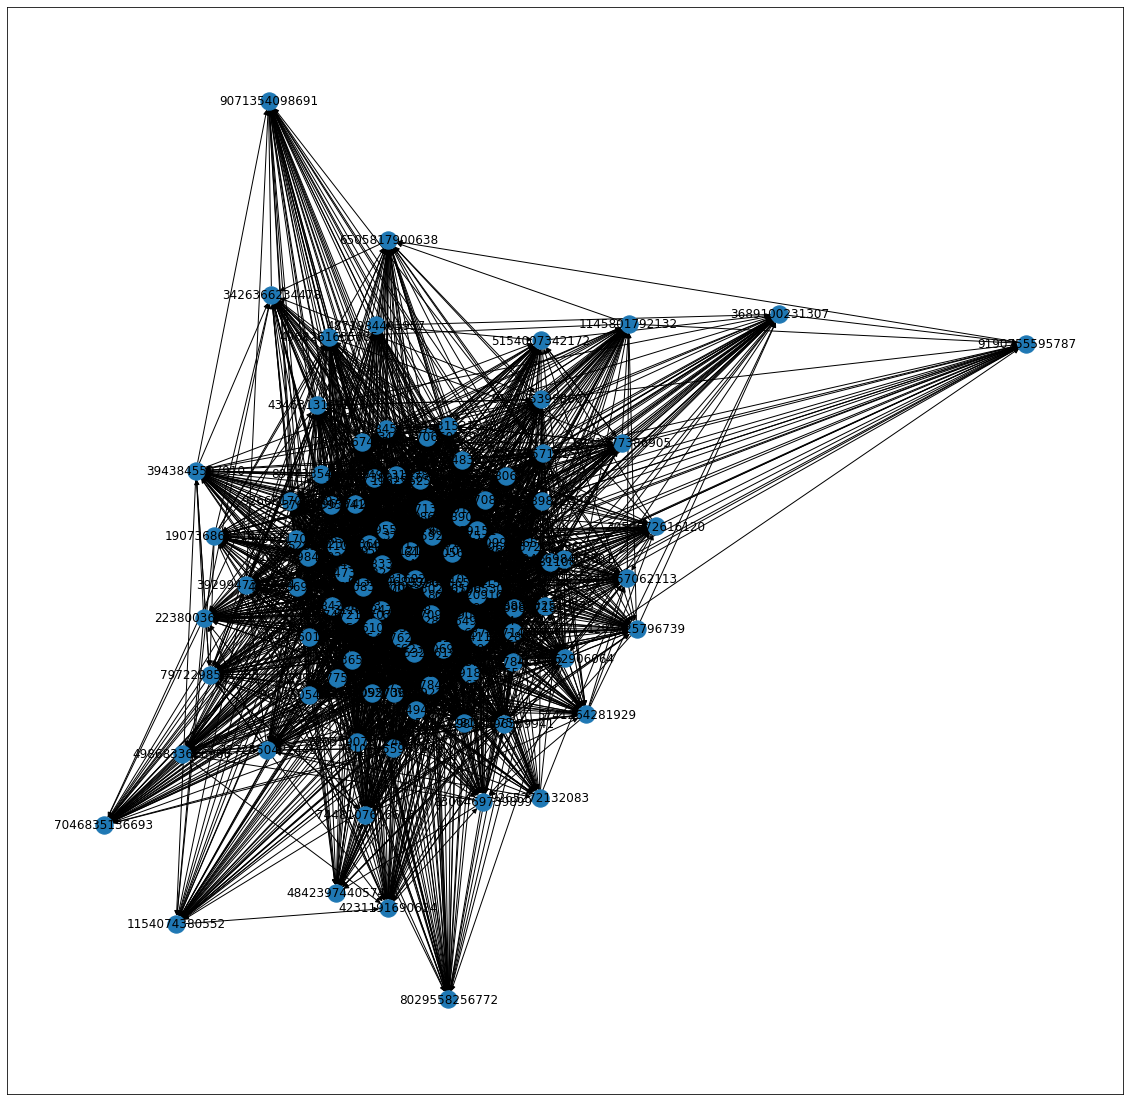

In [24]:
pos = nx.spring_layout(G_asymmetric)
betCent = nx.betweenness_centrality(G_asymmetric, normalized=False, endpoints=False)
node_color = [20000.0 * G_asymmetric.degree(v) for v in G_asymmetric]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G_asymmetric,pos=pos)

In [25]:
#Shortest Path Network Analizi
nx.shortest_path(G_asymmetric, created_customers[0].msisdn, created_customers[50].msisdn)

['4849686902975', '7968437208296', '9177453998607']

In [26]:
#For HTML D3js Graph
for c in network_dict:
    print(c.split("->")[0]+","+c.split("->")[1]+","+str(network_dict[c]))

4849686902975,7003330266196,1
4849686902975,7046835136693,1
4849686902975,3929947385824,1
4849686902975,2238003679663,1
4849686902975,1879984510039,1
4849686902975,6158508360706,1
4849686902975,8029558256772,1
4849686902975,2553169233410,1
4849686902975,8236636627913,1
4849686902975,9867089001859,1
4849686902975,4134236512196,1
4849686902975,1145801792132,1
4849686902975,5042698460801,1
4849686902975,6400905634996,1
4849686902975,1038898409205,1
4849686902975,7448107616613,1
4849686902975,4968261635085,1
4849686902975,3541957191599,1
4849686902975,5287728190775,1
4849686902975,5522709573610,1
4849686902975,5454576244521,1
4849686902975,9071354098691,1
4849686902975,4346313194983,1
4849686902975,7998271397013,1
4849686902975,9696374212333,1
4849686902975,3943845597910,1
4849686902975,4842397440574,1
4849686902975,9806096539941,1
4849686902975,4305270994922,1
4849686902975,5424080683235,1
4849686902975,7968437208296,1
4849686902975,3756678447163,1
4849686902975,3272550422445,1
4849686902

In [27]:
G_weighted = nx.Graph()
for c in network_dict:
    G_weighted.add_edge(c.split("->")[0],c.split("->")[1], weight=network_dict[c])
    
print(nx.info(G_weighted))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 2850
Average degree:  57.0000


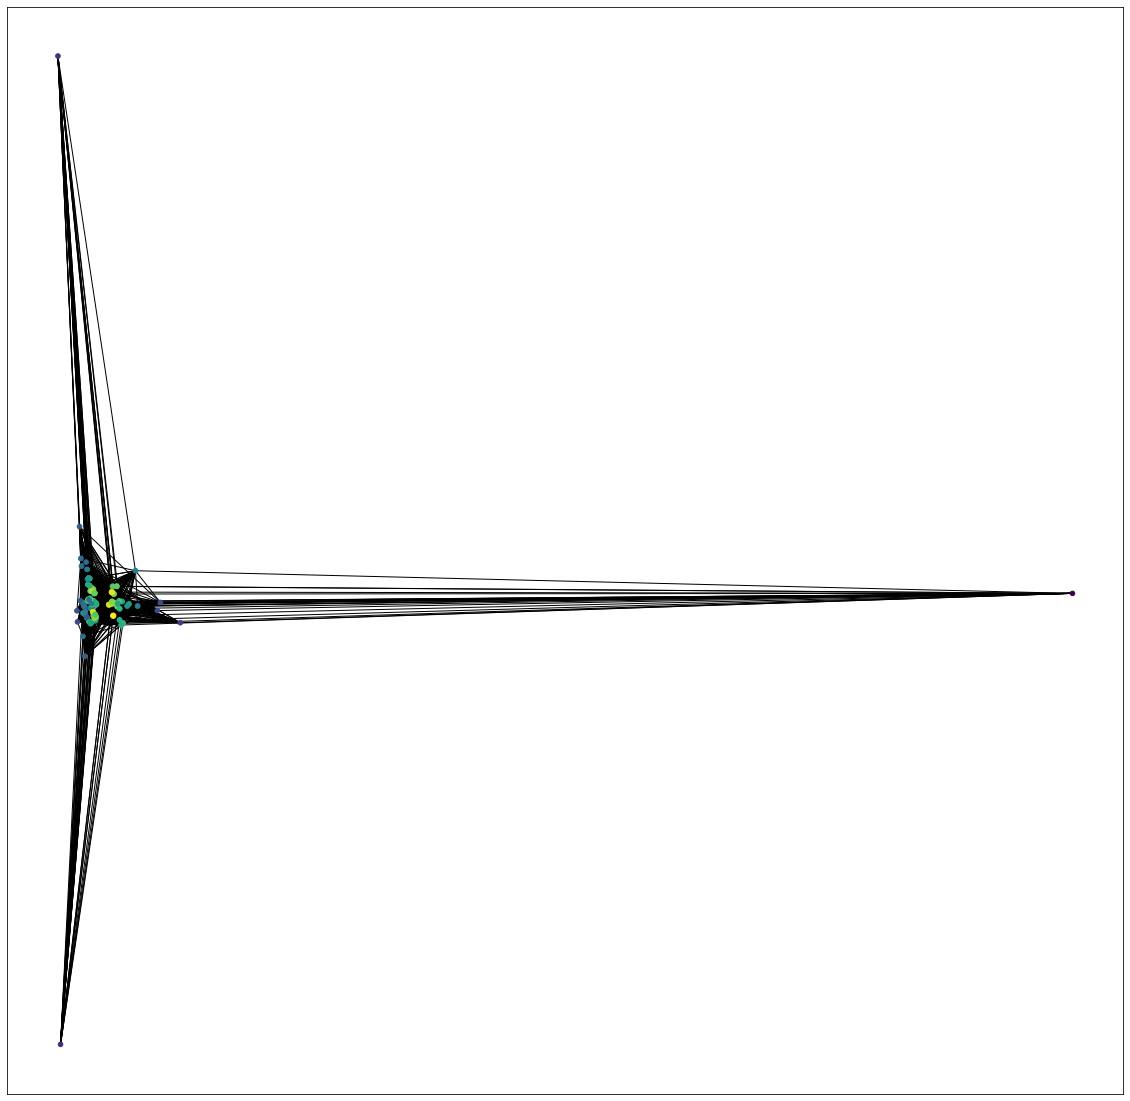

In [28]:
pos = nx.spectral_layout(G_weighted)
betCent = nx.betweenness_centrality(G_weighted, normalized=True, endpoints=True)
node_color = [20000.0 * G_weighted.degree(v) for v in G_weighted]
node_size =  [v * 1000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G_weighted, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )

In [29]:
G_symmetric = nx.Graph()
for c in network_dict:
    G_symmetric.add_edge(c.split("->")[0],c.split("->")[1])
    
print(nx.info(G_symmetric))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 2850
Average degree:  57.0000


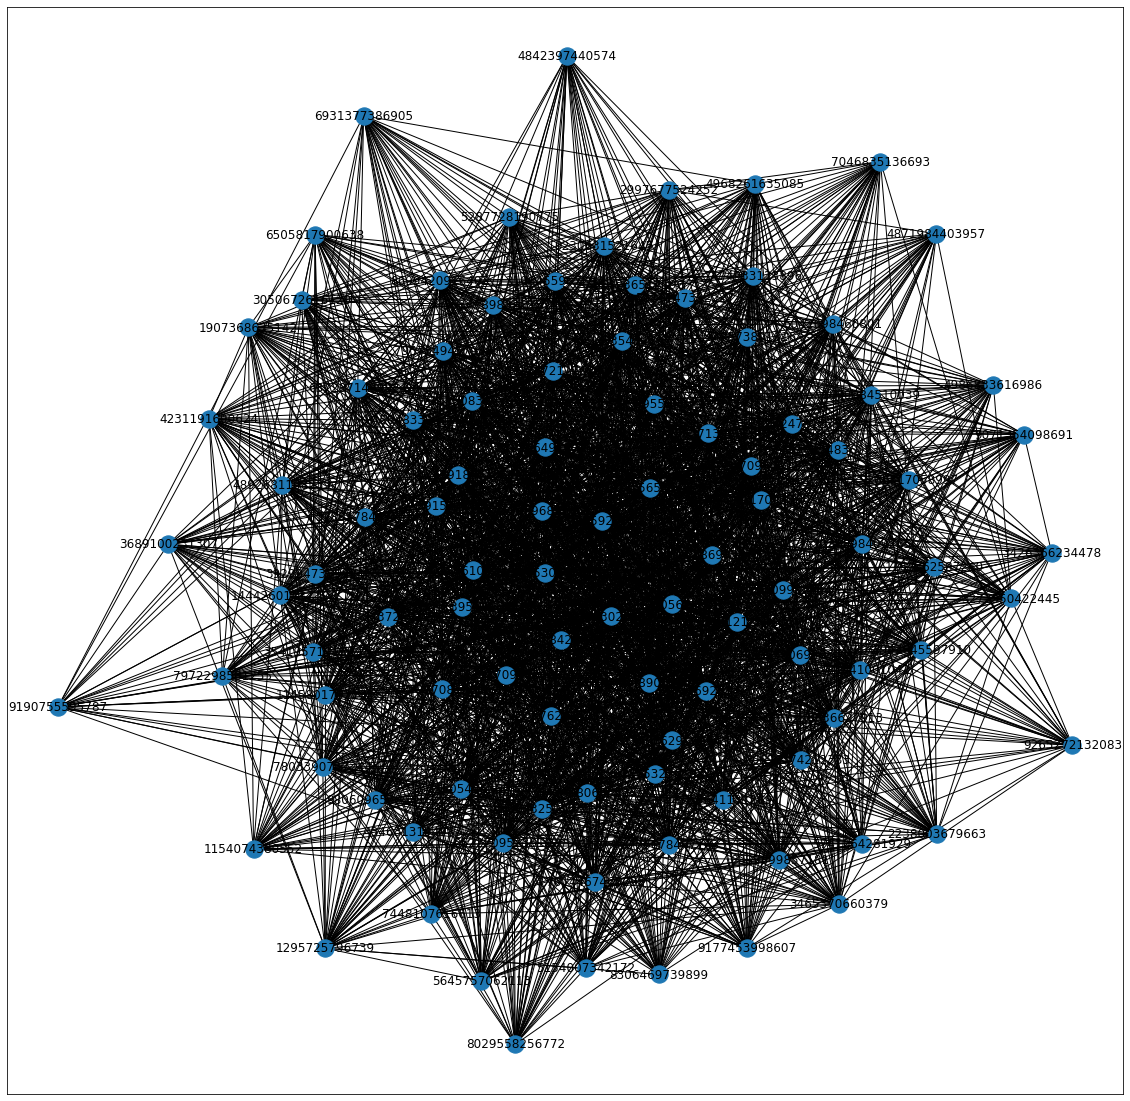

In [30]:
pos = nx.spring_layout(G_symmetric)
betCent = nx.betweenness_centrality(G_symmetric, normalized=True, endpoints=True)
node_color = [20000.0 * G_symmetric.degree(v) for v in G_symmetric]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G_symmetric,pos=pos)